# Multi-Token Experiments

The goal here is to run some quick + preliminary experiments on controlling 
multi-token generation. 
 * $|x_0|$ = `question_len` $\in$ [4, 8, 16, 32]
 * $|y|$ = `answer_len` $\in$ [2, 3, 4]
 * $|u| = k$ = greedy `1, 2, 3`, gcg `4, 8, 16, 32, 64`
     - GCG num_iters should be longer (3x)

We have 12 different question-answer length combinations. Let's assume each 
control experiment takes ~10 minutes. We have 16 hours to run these on 8 A100's, 
which means we can run (16 h/A100) * (8 A100) * (6 exp/h) = 768 experiments. 

768/12 = 64 experiments per question/answer length. 

**Generate the dataset**: 
```bash
python3 scripts/make_control_dataset.py \
    --out_file results/multi_token/mt_falcon_dataset_768.csv \
    --model_name tiiuae/falcon-7b \
    --question_lens 4 8 16 32 \
    --answer_lens 2 3 4 \
    --num_examples_per_qa_size 64
```

**Run the experiments**: 
```bash
CUDA_VISIBLE_DEVICES=0 bash scripts/multi_token_falcon7b.sh 0 32 # done
CUDA_VISIBLE_DEVICES=1 bash scripts/multi_token_falcon7b.sh 1 32 # done
CUDA_VISIBLE_DEVICES=2 bash scripts/multi_token_falcon7b.sh 2 32 # done
CUDA_VISIBLE_DEVICES=3 bash scripts/multi_token_falcon7b.sh 3 32 # done
CUDA_VISIBLE_DEVICES=4 bash scripts/multi_token_falcon7b.sh 4 32 # done
CUDA_VISIBLE_DEVICES=5 bash scripts/multi_token_falcon7b.sh 5 32 # done
CUDA_VISIBLE_DEVICES=6 bash scripts/multi_token_falcon7b.sh 6 32 # done
CUDA_VISIBLE_DEVICES=7 bash scripts/multi_token_falcon7b.sh 7 32 # done

CUDA_VISIBLE_DEVICES=0 bash scripts/multi_token_falcon7b.sh 8 32 # running on ssh1
CUDA_VISIBLE_DEVICES=1 bash scripts/multi_token_falcon7b.sh 9 32 # running on ssh2
CUDA_VISIBLE_DEVICES=2 bash scripts/multi_token_falcon7b.sh 10 32 # running on ssh3
CUDA_VISIBLE_DEVICES=3 bash scripts/multi_token_falcon7b.sh 11 32 # running on ssh4
CUDA_VISIBLE_DEVICES=4 bash scripts/multi_token_falcon7b.sh 12 32 # running on ssh5
CUDA_VISIBLE_DEVICES=5 bash scripts/multi_token_falcon7b.sh 13 32 # running on ssh6
CUDA_VISIBLE_DEVICES=6 bash scripts/multi_token_falcon7b.sh 14 32 # running on ssh7
CUDA_VISIBLE_DEVICES=7 bash scripts/multi_token_falcon7b.sh 15 32 # running on ssh8
```

In [1]:
# Import box 
import pandas as pd 
import numpy as np
import glob
import os
import matplotlib.pyplot as plt

from transformers import AutoTokenizer
from ast import literal_eval

/home/paperspace/Magic_Words/venv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
falcon_tokenizer = AutoTokenizer.from_pretrained("tiiuae/falcon-7b")
FIG_SIZE = (4, 3)

In [43]:
def add_zero_prompt_length(df_in): 
    # set prompt_length to zero when base_correct is true 
    df_in.loc[df_in['base_correct'] == True, 'prompt_length'] = 0
    return df_in
def overview_report(df_in): 
    print("Length of dataframe: ", len(df_in))
    print("Mean prompt correct (epsilon): \t", df_in['prompt_correct'].mean())
    print("Mean prompt correct with k <= 20: ", len(df_in[df_in['prompt_length'] <= 20]) / len(df_in))
    print("Mean base correct: \t\t", df_in['base_correct'].mean())
    print("Mean prompt length: \t\t", df_in['prompt_length'].mean())


In [44]:
def k_epsilon_line_plot(df_in,
                        title=None,
                        output_path=None, 
                        figsize=(6, 4), 
                        log_y=False, 
                        log_x=False): 
    # Placeholder for the final percentages
    results = []

    # For each unique question_length
    question_lengths = df_in['question_length'].unique().tolist()
    question_lengths.sort()
    for q_len in question_lengths:
        # Filter the dataframe
        temp_df = df_in[df_in['question_length'] == q_len]

        percentage_correct = []
        prompt_lengths = sorted(temp_df['prompt_length'].unique())
        prompt_lengths = [0] + prompt_lengths
        for p_len in prompt_lengths:
            # Calculate the percentage for this prompt_length
            portion = temp_df[temp_df['prompt_length'] <= p_len]
            correct = portion['prompt_correct'].sum()
            total = len(temp_df)
            # print("Prompt length: ", p_len)
            percentage = 1-(correct/total)
            percentage_correct.append((p_len, percentage))

        results.append((q_len, percentage_correct))

    # Plotting
    plt.figure(figsize=figsize)

    for q_len, percentages in results:
        x, y = zip(*percentages)
        y = np.array(y)
        plt.plot(x, y, label=f'|x_0| = {q_len}')

    plt.xlabel('Prompt Length [k]')

    
    
    # logarithmic y-axis 
    if log_y: 
        plt.yscale('log')
        plt.ylabel('Log(Portion Incorrect) [log(ϵ)]')
    else:
        plt.ylabel('Portion Incorrect [ϵ]')
    
    # logarithmic x-axis
    if log_x: 
        plt.xscale('log')
        plt.xlabel('Log(Prompt Length) [log(k)]')
    else: 
        plt.xlabel('Prompt Length [k]')

    if title != None: 
        plt.title(title)
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    # plt.yscale('log')
    if output_path is not None:
        plt.savefig(output_path, dpi=300)
    return results


In [101]:
def ans_len_sorted_k_epsilon_line_plot(df_in,
                        title=None,
                        output_path=None, 
                        figsize=(6, 4), 
                        log_y=False, 
                        log_x=False): 
    # Placeholder for the final percentages
    results = []

    # For each unique question_length
    answer_lengths = df_in['answer_length'].unique().tolist()
    answer_lengths.sort()
    for a_len in answer_lengths:
        # Filter the dataframe
        temp_df = df_in[df_in['answer_length'] == a_len]

        percentage_correct = []
        prompt_lengths = sorted(temp_df['prompt_length'].unique())
        prompt_lengths = [0] + prompt_lengths
        for p_len in prompt_lengths:
            # Calculate the percentage for this prompt_length
            portion = temp_df[temp_df['prompt_length'] <= p_len]
            correct = portion['prompt_correct'].sum()
            total = len(temp_df)
            # print("Prompt length: ", p_len)
            percentage = 1-(correct/total)
            percentage_correct.append((p_len, percentage))

        results.append((a_len, percentage_correct))

    # Plotting
    plt.figure(figsize=figsize)

    for q_len, percentages in results:
        x, y = zip(*percentages)
        y = np.array(y)
        plt.plot(x, y, label=f'|y| = {q_len}')

    plt.xlabel('Prompt Length [k]')

    
    
    # logarithmic y-axis 
    if log_y: 
        plt.yscale('log')
        plt.ylabel('Log(Portion Incorrect) [log(ϵ)]')
    else:
        plt.ylabel('Portion Incorrect [ϵ]')
    
    # logarithmic x-axis
    if log_x: 
        plt.xscale('log')
        plt.xlabel('Log(Prompt Length) [log(k)]')
    else: 
        plt.xlabel('Prompt Length [k]')

    if title != None: 
        plt.title(title)
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    # plt.yscale('log')
    if output_path is not None:
        plt.savefig(output_path, dpi=300)
    return results


In [102]:
def loss_k_correlation_plots(df_in, 
                             suptitle=None, 
                             output_path=None, 
                             figsize=(8, 9)):
    solved_df = df_in[df_in['prompt_correct'] == 1]
    question_lengths = solved_df['question_length'].unique().tolist()
    question_lengths.sort()

    # make a 3 by 2 grid of plots
    fig, axs = plt.subplots(3, 2, figsize=figsize, sharex=True, sharey=True)
    # sharex and sharey
    print(question_lengths)
    # plot a scatter plot of base_correct vs. prompt_length
    for idx_, q_len in enumerate(question_lengths):
        # Filter the dataframe
        temp_df = df_in[df_in['question_length'] == q_len]
        idx = idx_ + 1
        axs[idx//2, idx%2].scatter(temp_df['base_loss'], temp_df['prompt_length'], alpha=0.5)
        axs[idx//2, idx%2].set_xlabel('Base Loss')
        axs[idx//2, idx%2].set_ylabel('Prompt Length [k]')

        # compute the Pearson correlation coefficient between base_loss and prompt_length
        corr = temp_df['base_loss'].corr(temp_df['prompt_length'])
        print(f'Pearson correlation coefficient (q_len={q_len}): {corr}')
        axs[idx//2, idx%2].set_title(f'Question Len {q_len}: Corr={corr:.2f}')

    # Now we add the overall plot in axs[0,0] 
    axs[0,0].scatter(solved_df['base_loss'], solved_df['prompt_length'], alpha=0.5, c='r')    
    axs[0,0].set_xlabel('Base Loss')
    axs[0,0].set_ylabel('Prompt Length [k]')
    corr = solved_df['base_loss'].corr(solved_df['prompt_length'])
    axs[0,0].set_title(f'All Question Lengths -- Corr={corr:.2f}')
    corr = solved_df['base_loss'].corr(solved_df['prompt_length'])

    # tight layout
    if suptitle != None: 
        plt.suptitle(suptitle)
    plt.tight_layout()

    if output_path is not None:
        plt.savefig(output_path, dpi=300)
    

In [103]:
def loss_k_correlation_plots(df_in, 
                             suptitle=None, 
                             output_path=None, 
                             figsize=(8, 9)):
    solved_df = df_in[df_in['prompt_correct'] == 1]
    question_lengths = solved_df['question_length'].unique().tolist()
    question_lengths.sort()

    # make a 3 by 2 grid of plots
    fig, axs = plt.subplots(3, 2, figsize=figsize, sharex=True, sharey=True)
    # sharex and sharey
    print(question_lengths)
    # plot a scatter plot of base_correct vs. prompt_length
    for idx_, q_len in enumerate(question_lengths):
        # Filter the dataframe
        temp_df = df_in[df_in['question_length'] == q_len]
        idx = idx_ + 1
        axs[idx//2, idx%2].scatter(temp_df['base_loss'], temp_df['prompt_length'], alpha=0.5)
        axs[idx//2, idx%2].set_xlabel('Base Loss')
        axs[idx//2, idx%2].set_ylabel('Prompt Length [k]')

        # compute the Pearson correlation coefficient between base_loss and prompt_length
        corr = temp_df['base_loss'].corr(temp_df['prompt_length'])
        print(f'Pearson correlation coefficient (q_len={q_len}): {corr}')
        axs[idx//2, idx%2].set_title(f'Question Len {q_len}: Corr={corr:.2f}')

    # Now we add the overall plot in axs[0,0] 
    axs[0,0].scatter(solved_df['base_loss'], solved_df['prompt_length'], alpha=0.5, c='r')    
    axs[0,0].set_xlabel('Base Loss')
    axs[0,0].set_ylabel('Prompt Length [k]')
    corr = solved_df['base_loss'].corr(solved_df['prompt_length'])
    axs[0,0].set_title(f'All Question Lengths -- Corr={corr:.2f}')
    corr = solved_df['base_loss'].corr(solved_df['prompt_length'])

    # tight layout
    if suptitle != None: 
        plt.suptitle(suptitle)
    plt.tight_layout()

    if output_path is not None:
        plt.savefig(output_path, dpi=300)
    

In [104]:
def get_prompt_token_freqs(df_in, 
                           tokenizer, 
                           num_to_prompt=20, 
                           title=None, 
                           figsize=(12, 3), 
                           output_path=None): 
    prompt_tokens = df_in[df_in['base_correct'] == False]['best_prompt_ids'].tolist()
    prompt_tokens = [literal_eval(x) for x in prompt_tokens]
    all_prompt_tokens = []
    for x in prompt_tokens: 
        all_prompt_tokens += x
    
    # all_prompt_tokens is a list of all the prompt tokens (including duplicates). 
    # We want to count the number of times each token appears in the list.
    # We can use a dictionary to do this.
    prompt_token_freqs = {}
    for token in all_prompt_tokens:
        if token in prompt_token_freqs:
            prompt_token_freqs[token] += 1
        else:
            prompt_token_freqs[token] = 1

    # now let's sort the dictionary by value
    prompt_token_freqs = {k: v for k, v in sorted(prompt_token_freqs.items(), key=lambda item: item[1], reverse=True)}


    # Let's plot the top 20 tokens
    top_20_tokens = list(prompt_token_freqs.keys())[:num_to_prompt]
    top_20_freqs = list(prompt_token_freqs.values())[:num_to_prompt]

    plt.figure(figsize=figsize)
    plt.bar([i for i in range(num_to_prompt)], top_20_freqs)
    plt.xticks([i for i in range(num_to_prompt)], [tokenizer.decode([x]) for x in top_20_tokens], rotation=90)
    plt.xlabel('Token')
    plt.ylabel('Frequency')

    if title != None: 
        plt.title(title)

    plt.tight_layout()

    if output_path is not None:
        plt.savefig(output_path, dpi=300)

    return prompt_token_freqs

## 1: `results/multi_token/falcon-7b/*.csv`

In [105]:
file_path = f'falcon-7b/mt768_*_of_32.csv'
file_list = glob.glob(file_path)
print(file_list)
df_list = []
for file in file_list:
    df_list.append(pd.read_csv(file))
df = pd.concat(df_list, ignore_index=True)
df.head()

['falcon-7b/mt768_4_of_32.csv', 'falcon-7b/mt768_3_of_32.csv', 'falcon-7b/mt768_1_of_32.csv', 'falcon-7b/mt768_6_of_32.csv', 'falcon-7b/mt768_7_of_32.csv', 'falcon-7b/mt768_5_of_32.csv', 'falcon-7b/mt768_0_of_32.csv', 'falcon-7b/mt768_2_of_32.csv']


,question,question_ids,answer,answer_ids,base_loss,search_method,best_prompt,best_prompt_ids,prompt_length,prompted_loss,base_correct,prompt_correct,question_length
0,American artists Little Fe,"[2281, 6517, 8527, 3948]",at and,"[249, 273]",0.765625,greedy,Both,[13191],1.0,0.079102,False,True,4.0
1,"wick, however","[10080, 204, 23, 2537]",",","[204, 23]",1.539062,greedy,onyms,[39540],1.0,0.507812,False,True,4.0
2,it reached number,"[334, 5283, 1386, 204]",28 on the,"[2086, 313, 248]",2.046875,gcg,/**,"[3853, 2086, 15506, 25765]",4.0,0.486328,False,True,4.0
3,The Apollo @,"[390, 32061, 204, 43]",-@ Soy,"[24, 43, 34372]",8.0,gcg,AT,"[1584, 18253, 34372, 3190, 29757, 12446, 43611...",8.0,0.421875,False,True,4.0
4,@-@ times,"[43, 24, 43, 1762]",platinum by the Recording,"[29597, 431, 248, 41171]",7.125,gcg,Topics,"[23872, 29394, 8271, 3566, 46167, 10116, 27833...",8.0,0.718750,False,True,4.0


In [106]:
# Save the dataframe to a csv file 
SAVE = False
if SAVE: 
    output_path = 'falcon-7b/mt768_results.csv'
    # check if it exists
    if os.path.exists(output_path) and False:
        print("File already exists")
    else: 
        print(f"Saving dive1 to {output_path}")
        df.to_csv(output_path, index=False, lineterminator='\n')

In [107]:
df['answer_ids'][0]

'[249, 273]'

In [108]:
# ensure df['answer_ids'] is of type string
df['answer_ids'] = df['answer_ids'].astype(str)
answer_ids_eval = df['answer_ids'].apply(literal_eval)
# loop thru. if type != list, make it a list 
for idx, x in enumerate(answer_ids_eval): 
    if type(x) != list: 
        answer_ids_eval[idx] = [x]

df['answer_length'] = [len(x) for x in answer_ids_eval] 

In [109]:
# adding a new 'answer_length' column: 
# df['answer_length'] = df['answer_ids'].apply(lambda x: 1 if type(literal_eval(x)) != list else len(literal_eval(x)))
df.columns

Index(['question', 'question_ids', 'answer', 'answer_ids', 'base_loss',
       'search_method', 'best_prompt', 'best_prompt_ids', 'prompt_length',
       'prompted_loss', 'base_correct', 'prompt_correct', 'question_length',
       'answer_length'],
      dtype='object')

In [110]:
overview_report(df)

Length of dataframe:  193
Mean prompt correct (epsilon): 	 0.8795811518324608
Mean prompt correct with k <= 20:  0.7202072538860104
Mean base correct: 		 0.09424083769633508
Mean prompt length: 		 18.146596858638745


In [111]:
# overview
answer_lengths = df['answer_length'].unique()
for al in answer_lengths: 
    print("\nAnswer Length: ", al)
    overview_report(df[df['answer_length'] == al])



Answer Length:  2
Length of dataframe:  64
Mean prompt correct (epsilon): 	 1.0
Mean prompt correct with k <= 20:  0.921875
Mean base correct: 		 0.203125
Mean prompt length: 		 6.453125

Answer Length:  3
Length of dataframe:  64
Mean prompt correct (epsilon): 	 0.8888888888888888
Mean prompt correct with k <= 20:  0.71875
Mean base correct: 		 0.06349206349206349
Mean prompt length: 		 18.682539682539684

Answer Length:  4
Length of dataframe:  64
Mean prompt correct (epsilon): 	 0.75
Mean prompt correct with k <= 20:  0.53125
Mean base correct: 		 0.015625
Mean prompt length: 		 29.3125

Answer Length:  1
Length of dataframe:  1
Mean prompt correct (epsilon): 	 nan
Mean prompt correct with k <= 20:  0.0
Mean base correct: 		 nan
Mean prompt length: 		 nan


In [112]:
df['answer_length'].unique()

array([2, 3, 4, 1])

In [113]:
df[df['answer_length'] == 1]
# remove it 
df = df[df['answer_length'] != 1]
df['answer_length'].unique()

array([2, 3, 4])

In [114]:
df['question_length'].unique()
# eliminate nan
df = df.dropna(subset=['question_length'])


Answer Length:  2



Answer Length:  3

Answer Length:  4


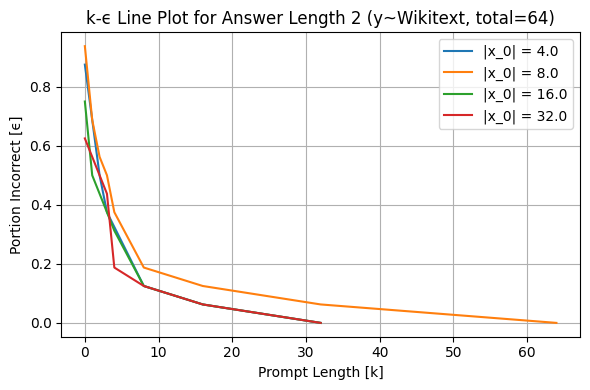

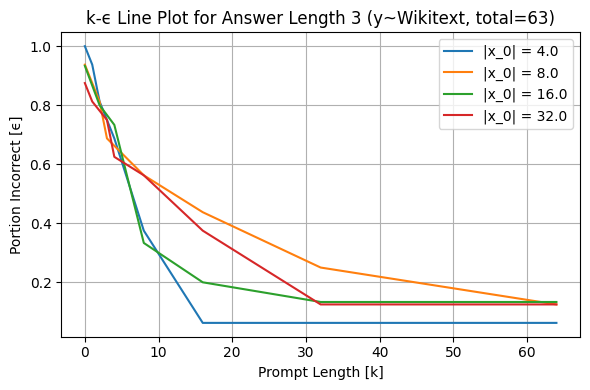

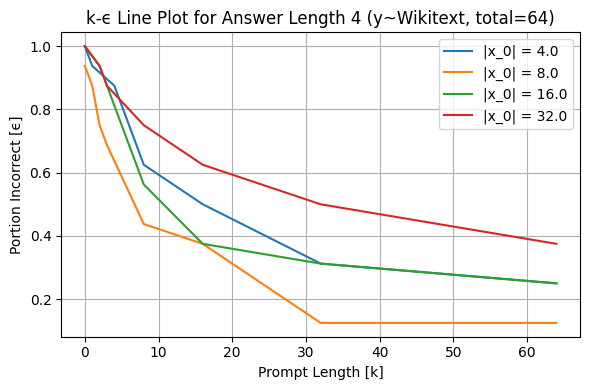

In [115]:
# overview
answer_lengths = df['answer_length'].unique()
for al in answer_lengths: 
    print("\nAnswer Length: ", al)
    num_examples = len(df[df['answer_length'] == al])
    k_epsilon_line_plot(df[df['answer_length'] == al],
                        title=f"k-ϵ Line Plot for Answer Length {al} (y~Wikitext, total={num_examples})",
                        output_path='prelim_multi_token_results.png', 
                        figsize=(6, 4), 
                        log_y=False, 
                        log_x=False)

[(4.0,
  [(0, 0.9583333333333334),
   (0.0, 0.9583333333333334),
   (1.0, 0.8541666666666666),
   (2.0, 0.75),
   (3.0, 0.7083333333333333),
   (4.0, 0.6458333333333333),
   (8.0, 0.375),
   (16.0, 0.20833333333333337),
   (32.0, 0.125),
   (64.0, 0.10416666666666663)]),
 (8.0,
  [(0, 0.9375),
   (0.0, 0.9375),
   (1.0, 0.8125),
   (2.0, 0.7083333333333333),
   (3.0, 0.625),
   (4.0, 0.5833333333333333),
   (8.0, 0.39583333333333337),
   (16.0, 0.3125),
   (32.0, 0.14583333333333337),
   (64.0, 0.08333333333333337)]),
 (16.0,
  [(0, 0.8936170212765957),
   (0.0, 0.8936170212765957),
   (1.0, 0.7872340425531915),
   (2.0, 0.7234042553191489),
   (3.0, 0.7021276595744681),
   (4.0, 0.6595744680851063),
   (8.0, 0.34042553191489366),
   (16.0, 0.21276595744680848),
   (32.0, 0.14893617021276595),
   (64.0, 0.12765957446808507)]),
 (32.0,
  [(0, 0.8333333333333334),
   (0.0, 0.8333333333333334),
   (1.0, 0.7916666666666666),
   (2.0, 0.75),
   (3.0, 0.6875),
   (4.0, 0.5625),
   (8.0, 0.47

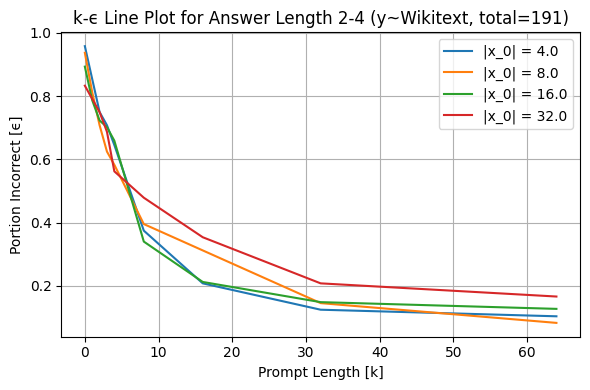

In [116]:
# print("\nAnswer Length: ", al)
num_examples = len(df)
k_epsilon_line_plot(df,
                    title=f"k-ϵ Line Plot for Answer Length 2-4 (y~Wikitext, total={num_examples})",
                    output_path='prelim_multi_token_results.png', 
                    figsize=(6, 4), 
                    log_y=False, 
                    log_x=False)

In [118]:
df['question_length'].unique()

array([ 4.,  8., 16., 32.])

[(2,
  [(0, 0.796875),
   (0.0, 0.796875),
   (1.0, 0.609375),
   (2.0, 0.5),
   (3.0, 0.421875),
   (4.0, 0.3125),
   (8.0, 0.140625),
   (16.0, 0.078125),
   (32.0, 0.015625),
   (64.0, 0.0)]),
 (3,
  [(0, 0.9365079365079365),
   (0.0, 0.9365079365079365),
   (1.0, 0.873015873015873),
   (2.0, 0.8095238095238095),
   (3.0, 0.7619047619047619),
   (4.0, 0.6825396825396826),
   (8.0, 0.46031746031746035),
   (16.0, 0.2698412698412699),
   (32.0, 0.1428571428571429),
   (64.0, 0.11111111111111116)]),
 (4,
  [(0, 0.984375),
   (0.0, 0.984375),
   (1.0, 0.953125),
   (2.0, 0.890625),
   (3.0, 0.859375),
   (4.0, 0.84375),
   (8.0, 0.59375),
   (16.0, 0.46875),
   (32.0, 0.3125),
   (64.0, 0.25)])]

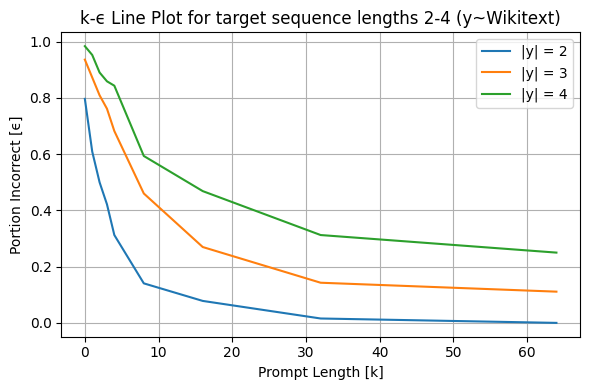

In [121]:
ans_len_sorted_k_epsilon_line_plot(df, 
                                   title=f'k-ϵ Line Plot for target sequence lengths 2-4 (y~Wikitext)',
                                  output_path='prelim_multi_token_results.png', 
                                  figsize=(6, 4), 
                                  log_y=False, 
                                  log_x=False)